In [ ]:
import pandas as pd

df = pd.read_csv('ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
import os
import pandas as pd
from glob import glob


dataset_path = "ham10000"
csv_path = os.path.join(dataset_path, "HAM10000_metadata.csv")
image_dir_1 = os.path.join(dataset_path, "HAM10000_images_part_1")
image_dir_2 = os.path.join(dataset_path, "HAM10000_images_part_2")


df = pd.read_csv(csv_path)


all_image_paths = glob(os.path.join(image_dir_1, '*.jpg')) + glob(os.path.join(image_dir_2, '*.jpg'))


imageid_path_dict = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in all_image_paths
}


df['image_path'] = df['image_id'].map(imageid_path_dict)


df = df[df['image_path'].notnull()]

print(f" Combined dataset shape: {df.shape}")
print(df[['image_id', 'image_path']].head())


 Combined dataset shape: (10015, 8)
       image_id                                        image_path
0  ISIC_0027419  ham10000/HAM10000_images_part_1/ISIC_0027419.jpg
1  ISIC_0025030  ham10000/HAM10000_images_part_1/ISIC_0025030.jpg
2  ISIC_0026769  ham10000/HAM10000_images_part_1/ISIC_0026769.jpg
3  ISIC_0025661  ham10000/HAM10000_images_part_1/ISIC_0025661.jpg
4  ISIC_0031633  ham10000/HAM10000_images_part_2/ISIC_0031633.jpg


In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,ham10000/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,ham10000/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,ham10000/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,ham10000/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,ham10000/HAM10000_images_part_2/ISIC_0031633.jpg


In [ ]:
print(f" Total entries in df: {df.shape[0]}")
print(f" Columns in df: {df.shape[1]}")

 Total entries in df: 10015
 Columns in df: 8


In [ ]:
print("Image count per original class (dx):")
print(df['dx'].value_counts())


Image count per original class (dx):
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])


print("Encoded class labels:", dict(zip(le.classes_, range(len(le.classes_)))))


Encoded class labels: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
from sklearn.model_selection import train_test_split

#Approx 70-20-10 train, val, split
train_val_df, test_df = train_test_split(
    df,
    test_size=0.10,
    stratify=df['label'],
    random_state=42
)



train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.222,
    stratify=train_val_df['label'],
    random_state=42
)


print("Train class distribution:\n", train_df['label'].value_counts())
print("\nVal class distribution:\n", val_df['label'].value_counts())
print("\nTest class distribution:\n", test_df['label'].value_counts())


Train class distribution:
 label
5    4694
4     780
2     769
1     360
0     229
6     100
3      80
Name: count, dtype: int64

Val class distribution:
 label
5    1340
4     222
2     220
1     103
0      65
6      28
3      23
Name: count, dtype: int64

Test class distribution:
 label
5    671
4    111
2    110
1     51
0     33
6     14
3     12
Name: count, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam


INPUT_SHAPE = (299, 299, 3)
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = len(df['label'].unique())




train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=42
)









Found 7012 validated image filenames belonging to 7 classes.
Found 2001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3
def build_inception_model(input_shape=(299, 299, 3), num_classes=7):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_inception_model(INPUT_SHAPE, NUM_CLASSES)

2025-04-18 12:41:20.132028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79195 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("keras_best_inception_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Training model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20


2025-04-18 12:41:38.485096: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-18 12:41:38.565347: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-18 12:41:38.718615: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-18 12:41:41.354965: I external/local_xla/xla/service/service.cc:168] XLA service 0x15533c7f84d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-18 12:41:41.355004: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-04-18 12:41:41.359983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745005301.424527 2441521 device_compiler.h:

220/220 [==============================] - ETA: 0s - loss: 1.7213 - accuracy: 0.5555
Epoch 1: val_accuracy improved from -inf to 0.66467, saving model to keras_best_inception_model.h5


/packages/envs/tensorflow-gpu-2.15.0/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


220/220 [==============================] - 145s 544ms/step - loss: 1.7213 - accuracy: 0.5555 - val_loss: 1.3396 - val_accuracy: 0.6647
Epoch 2/20
220/220 [==============================] - ETA: 0s - loss: 1.0465 - accuracy: 0.7228
Epoch 2: val_accuracy improved from 0.66467 to 0.73763, saving model to keras_best_inception_model.h5
220/220 [==============================] - 115s 523ms/step - loss: 1.0465 - accuracy: 0.7228 - val_loss: 1.1334 - val_accuracy: 0.7376
Epoch 3/20
220/220 [==============================] - ETA: 0s - loss: 0.8839 - accuracy: 0.7625
Epoch 3: val_accuracy improved from 0.73763 to 0.76712, saving model to keras_best_inception_model.h5
220/220 [==============================] - 116s 526ms/step - loss: 0.8839 - accuracy: 0.7625 - val_loss: 0.8269 - val_accuracy: 0.7671
Epoch 4/20
220/220 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.7775
Epoch 4: val_accuracy did not improve from 0.76712
220/220 [==============================] - 113s 514m

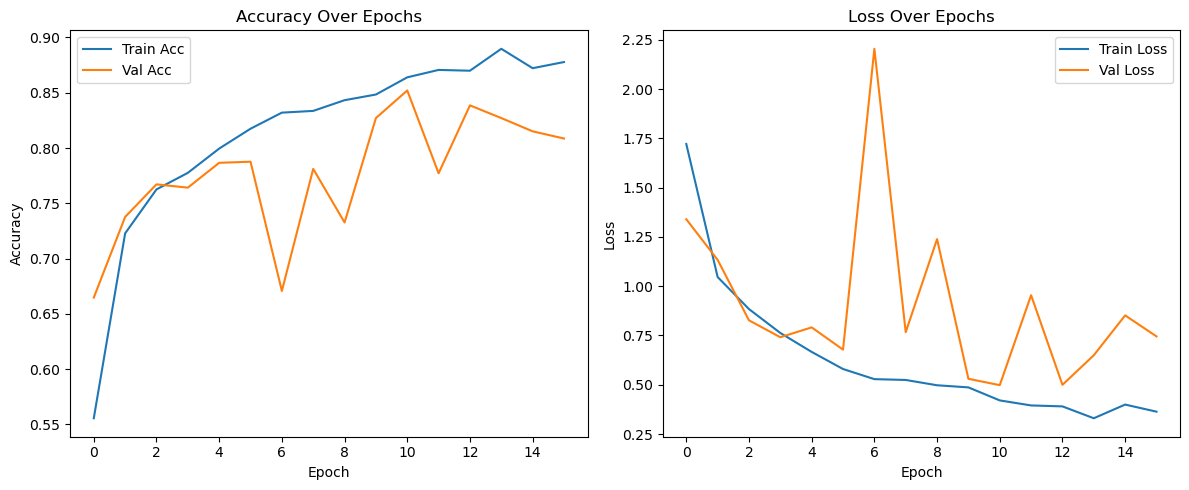

In [ ]:
# Ploting training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


32/32 [==============================] - 7s 210ms/step


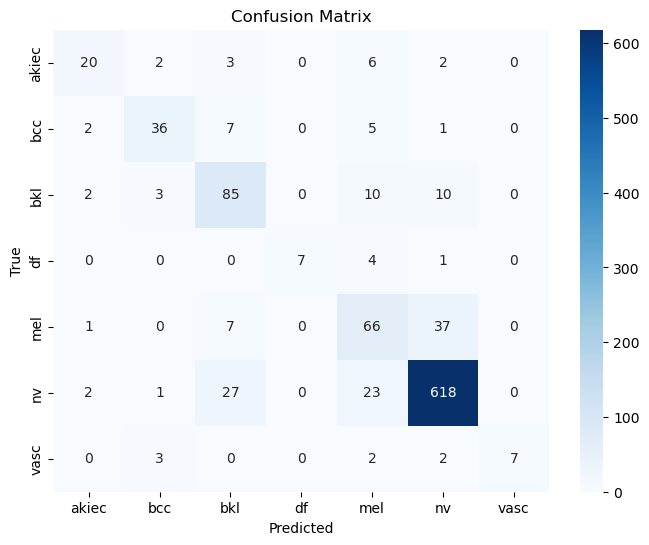

In [ ]:
# Loading best model
best_model = load_model("keras_best_inception_model.h5")

# Evaluating on test set
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))


              precision    recall  f1-score   support

       akiec       0.74      0.61      0.67        33
         bcc       0.80      0.71      0.75        51
         bkl       0.66      0.77      0.71       110
          df       1.00      0.58      0.74        12
         mel       0.57      0.59      0.58       111
          nv       0.92      0.92      0.92       671
        vasc       1.00      0.50      0.67        14

    accuracy                           0.84      1002
   macro avg       0.81      0.67      0.72      1002
weighted avg       0.84      0.84      0.84      1002



Image: ISIC_0029448.jpg
True Label: vasc | Predicted: nv


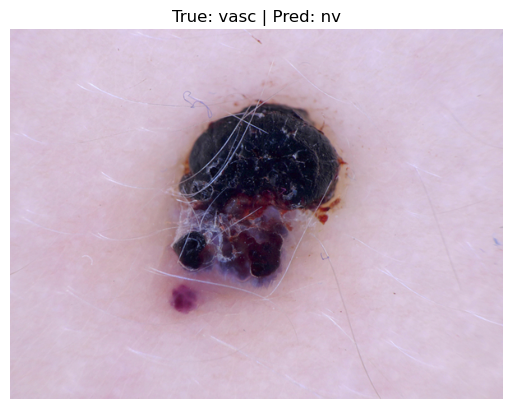

Image: ISIC_0031117.jpg
True Label: nv | Predicted: nv


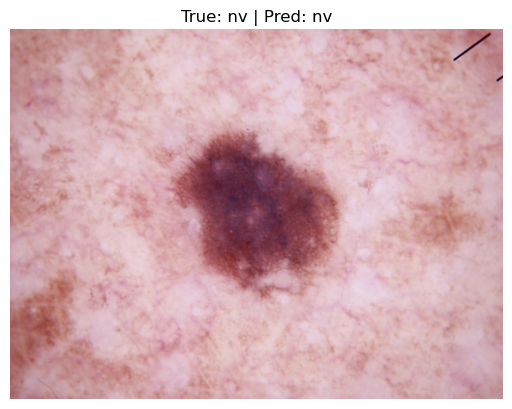

Image: ISIC_0028896.jpg
True Label: nv | Predicted: nv


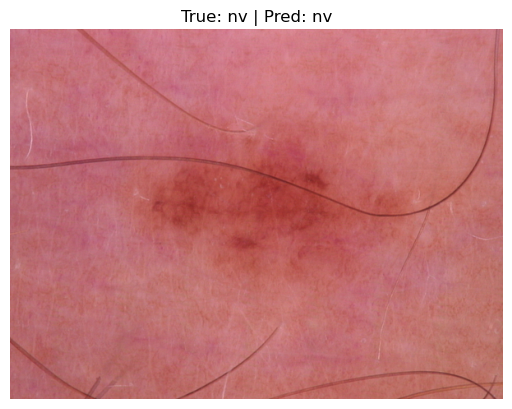

Image: ISIC_0032756.jpg
True Label: bkl | Predicted: bkl


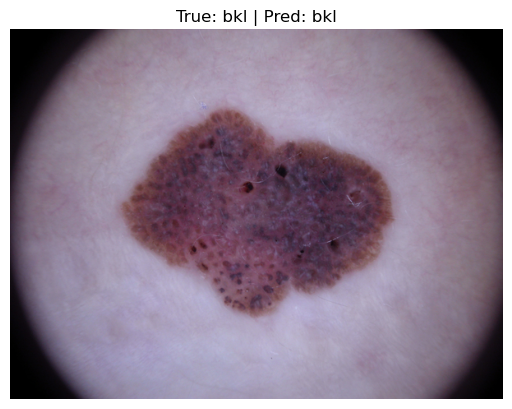

Image: ISIC_0026791.jpg
True Label: nv | Predicted: nv


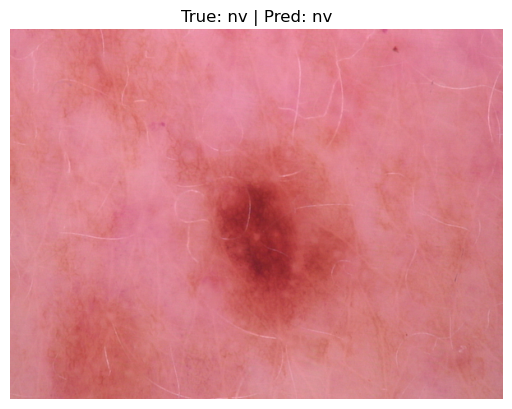

Image: ISIC_0033988.jpg
True Label: nv | Predicted: nv


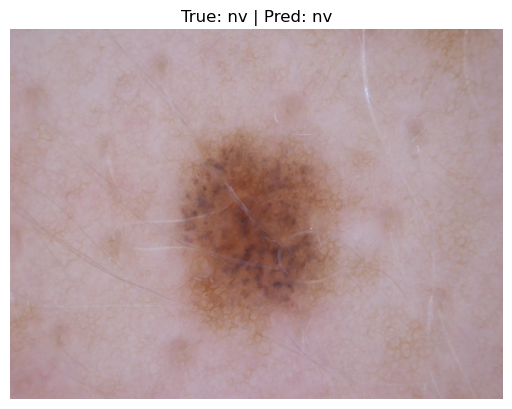

Image: ISIC_0033447.jpg
True Label: nv | Predicted: nv


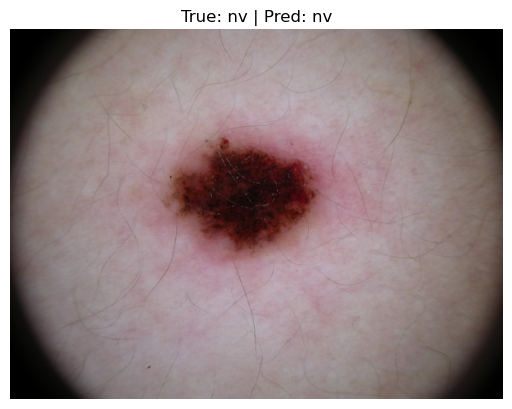

Image: ISIC_0030425.jpg
True Label: nv | Predicted: bkl


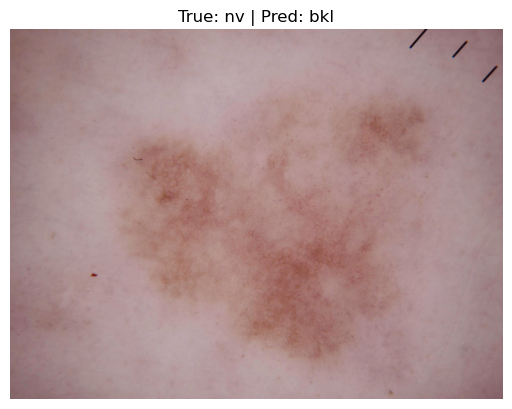

Image: ISIC_0030612.jpg
True Label: nv | Predicted: nv


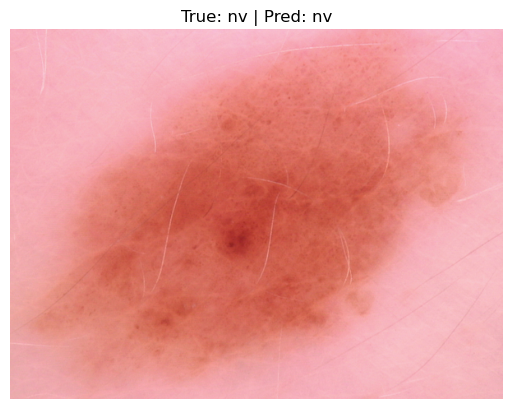

Image: ISIC_0024359.jpg
True Label: nv | Predicted: nv


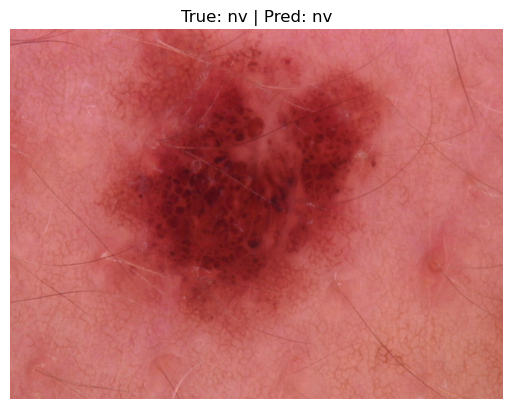

In [ ]:
import random
from PIL import Image


filenames = test_generator.filenames
true_labels = y_true
pred_labels = y_pred


random_indices = random.sample(range(len(filenames)), 10)

# Display predictions
for i in random_indices:
    image_path = os.path.join(test_generator.directory, filenames[i])
    true_class = le.inverse_transform([true_labels[i]])[0]
    pred_class = le.inverse_transform([pred_labels[i]])[0]

    print(f"Image: {os.path.basename(image_path)}")
    print(f"True Label: {true_class} | Predicted: {pred_class}")

    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {true_class} | Pred: {pred_class}")
    plt.show()


#References:

1. https://keras.io/api/applications/inceptionv3/
2. https://keras.io/api/applications/
3. https://www.tensorflow.org/tutorials/images/transfer_learning
4. https://www.geeksforgeeks.org/transfer-learning-fine-tuning-using-keras/#
5. https://chatgpt.com/share/6803482f-ed4c-8004-aaae-c19140fae67e